##### Copyright 2020 The TensorFlow IO Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Streaming structured data from Elasticsearch using Tensorflow-IO

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/io/tutorials/elasticsearch"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/elasticsearch.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/io/blob/master/docs/tutorials/elasticsearch.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
      <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/io/docs/tutorials/elasticsearch.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This tutorial focuses on streaming data from an [Elasticsearch](https://www.elastic.co/guide/en/elasticsearch/reference/current/elasticsearch-intro.html) cluster into a `tf.data.Dataset` which is then used in conjunction with `tf.keras` for training and inference.

Elasticseach is primarily a distributed search engine which supports storing structured, unstructured, geospatial, numeric data etc. For the purpose of this tutorial, a dataset with structured records is utilized.

**NOTE:** A basic understanding of [elasticsearch storage](https://www.elastic.co/guide/en/elasticsearch/reference/current/documents-indices.html) will help you in following the tutorial with ease.

## Setup packages

The `elasticsearch` package is utilized for preparing and storing the data within elasticsearch indices for demonstration purposes only. In real-world production clusters with numerous nodes, the cluster might be receiving the data from connectors like logstash etc.

Once the data is available in the elasticsearch cluster, only `tensorflow-io` is required to stream the data into the models.


### Install the required tensorflow-io and elasticsearch packages

In [2]:
!pip install tensorflow-io
!pip install elasticsearch


### Import packages

In [3]:
import os
import time
from sklearn.model_selection import train_test_split
from elasticsearch import Elasticsearch
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_io as tfio

### Validate tf and tfio imports

In [4]:
print("tensorflow-io version: {}".format(tfio.__version__))
print("tensorflow version: {}".format(tf.__version__))

tensorflow-io version: 0.16.0
tensorflow version: 2.3.0


## Download and setup the Elasticsearch instance

For demo purposes, the open-source version of the elasticsearch package is used.


In [5]:
%%bash

wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512
tar -xzf elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
sudo chown -R daemon:daemon elasticsearch-7.9.2/
shasum -a 512 -c elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512 

elasticsearch-oss-7.9.2-linux-x86_64.tar.gz: OK


Run the instance as a daemon process

In [6]:
%%bash --bg

sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch

Starting job # 0 in a separate thread.


In [7]:
# Sleep for few seconds to let the instance start.
time.sleep(20)

Once the instance has been started, grep for `elasticsearch` in the processes list to confirm the availability.

In [8]:
%%bash

ps -ef | grep elasticsearch

root         144     142  0 21:24 ?        00:00:00 sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch
daemon       145     144 86 21:24 ?        00:00:17 /content/elasticsearch-7.9.2/jdk/bin/java -Xshare:auto -Des.networkaddress.cache.ttl=60 -Des.networkaddress.cache.negative.ttl=10 -XX:+AlwaysPreTouch -Xss1m -Djava.awt.headless=true -Dfile.encoding=UTF-8 -Djna.nosys=true -XX:-OmitStackTraceInFastThrow -XX:+ShowCodeDetailsInExceptionMessages -Dio.netty.noUnsafe=true -Dio.netty.noKeySetOptimization=true -Dio.netty.recycler.maxCapacityPerThread=0 -Dio.netty.allocator.numDirectArenas=0 -Dlog4j.shutdownHookEnabled=false -Dlog4j2.disable.jmx=true -Djava.locale.providers=SPI,COMPAT -Xms1g -Xmx1g -XX:+UseG1GC -XX:G1ReservePercent=25 -XX:InitiatingHeapOccupancyPercent=30 -Djava.io.tmpdir=/tmp/elasticsearch-16913031424109346409 -XX:+HeapDumpOnOutOfMemoryError -XX:HeapDumpPath=data -XX:ErrorFile=logs/hs_err_pid%p.log -Xlog:gc*,gc+age=trace,safepoint:file=logs/gc.log:utctime,pid,tags:fileco

query the base endpoint to retrieve information about the cluster.

In [9]:
%%bash

curl -sX GET "localhost:9200/"

{
  "name" : "d1bc7d054c69",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "P8YXfKqYS-OS3k9CdMmlsw",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "oss",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


### Explore the dataset

For the purpose of this tutorial, lets download the [PetFinder](https://www.kaggle.com/c/petfinder-adoption-prediction) dataset and feed the data into elasticsearch manually. The goal of this classification problem is predict if the pet will be adopted or not.


In [10]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'
tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
pf_df = pd.read_csv(csv_file)

1671168/1668792 [==============================] - 0s 0us/step


In [11]:
pf_df.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


For the purpose of the tutorial, modifications are made to the label column.
0 will indicate the pet was not adopted, and 1 will indicate that it was.


In [12]:
# In the original dataset "4" indicates the pet was not adopted.
pf_df['target'] = np.where(pf_df['AdoptionSpeed']==4, 0, 1)

# Drop un-used columns.
pf_df = pf_df.drop(columns=['AdoptionSpeed', 'Description'])


In [13]:
# Number of datapoints and columns
len(pf_df), len(pf_df.columns)

(11537, 14)

### Split the dataset


In [14]:
train_df, test_df = train_test_split(pf_df, test_size=0.3, shuffle=True)
print("Number of training samples: ",len(train_df))
print("Number of testing sample: ",len(test_df))


Number of training samples:  8075
Number of testing sample:  3462


### Store the train and test data in elasticsearch indices

Storing the data in the local elasticsearch cluster simulates an environment for continuous remote data retrieval for training and inference purposes.

In [15]:
ES_NODES = "http://localhost:9200"

def prepare_es_data(index, doc_type, df):
  records = df.to_dict(orient="records")
  es_data = []
  for idx, record in enumerate(records):
    meta_dict = {
          "index": {
              "_index": index, 
              "_type": doc_type, 
              "_id": idx
          }
      }
    es_data.append(meta_dict)
    es_data.append(record)

  return es_data

def index_es_data(index, es_data):
  es_client = Elasticsearch(hosts = [ES_NODES])
  if es_client.indices.exists(index):
      print("deleting the '{}' index.".format(index))
      res = es_client.indices.delete(index=index)
      print("Response from server: {}".format(res))

  print("creating the '{}' index.".format(index))
  res = es_client.indices.create(index=index)
  print("Response from server: {}".format(res))

  print("bulk index the data")
  res = es_client.bulk(index=index, body=es_data, refresh = True)
  print("Errors: {}, Num of records indexed: {}".format(res["errors"], len(res["items"])))
  

In [16]:
train_es_data = prepare_es_data(index="train", doc_type="pet", df=train_df)
test_es_data = prepare_es_data(index="test", doc_type="pet", df=test_df)

index_es_data(index="train", es_data=train_es_data)
time.sleep(3)
index_es_data(index="test", es_data=test_es_data)

creating the 'train' index.
Response from server: {'acknowledged': True, 'shards_acknowledged': True, 'index': 'train'}
bulk index the data


/usr/local/lib/python3.6/dist-packages/elasticsearch/connection/base.py:190: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Errors: False, Num of records indexed: 8075
creating the 'test' index.
Response from server: {'acknowledged': True, 'shards_acknowledged': True, 'index': 'test'}
bulk index the data
Errors: False, Num of records indexed: 3462


## Prepare tfio datasets

Once the data is available in the cluster, only `tensorflow-io` is required to stream the data from the indices. The `elasticsearch.ElasticsearchIODataset` class is utilized for this purpose. The class inherits from `tf.data.Dataset` and thus exposes all the useful functionalities of `tf.data.Dataset` out of the box.


### Training dataset


In [17]:
BATCH_SIZE=32
HEADERS = {"Content-Type": "application/json"}

train_ds = tfio.experimental.elasticsearch.ElasticsearchIODataset(
        nodes=[ES_NODES],
        index="train",
        doc_type="pet",
        headers=HEADERS
    )

# Prepare a tuple of (features, label)
train_ds = train_ds.map(lambda v: (v, v.pop("target")))
train_ds = train_ds.batch(BATCH_SIZE)

Connection successful: http://localhost:9200/_cluster/health


### Testing dataset

In [18]:
test_ds = tfio.experimental.elasticsearch.ElasticsearchIODataset(
        nodes=[ES_NODES],
        index="test",
        doc_type="pet",
        headers=HEADERS
    )

# Prepare a tuple of (features, label)
test_ds = test_ds.map(lambda v: (v, v.pop("target")))
test_ds = test_ds.batch(BATCH_SIZE)

Connection successful: http://localhost:9200/_cluster/health


### Define the keras preprocessing layers

As per the [structured data tutorial](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers), it is recommended to use the [Keras Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) as they are more intuitive, and can be easily integrated with the models. However, the standard [feature_columns](https://www.tensorflow.org/api_docs/python/tf/feature_column) can also be used.

For a better understanding of the `preprocessing_layers` in classifying structured data, please refer to the [structured data tutorial](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers)

In [19]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_values=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

  # Prepare a Dataset that only yields our feature.
  feature_ds = feature_ds.map(index)

  # Learn the space of possible indices.
  encoder.adapt(feature_ds)

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so you can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))


Fetch a batch and observe the features of a sample record. This will help in defining the keras preprocessing layers for training the `tf.keras` model.

In [20]:
ds_iter = iter(train_ds)
features, label = next(ds_iter)
{key: value.numpy()[0] for key,value in features.items()}

{'Age': 2,
 'Breed1': b'Tabby',
 'Color1': b'Black',
 'Color2': b'Cream',
 'Fee': 0,
 'FurLength': b'Short',
 'Gender': b'Male',
 'Health': b'Healthy',
 'MaturitySize': b'Small',
 'PhotoAmt': 4,
 'Sterilized': b'No',
 'Type': b'Cat',
 'Vaccinated': b'No'}

Choose a subset of features.

In [21]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

# Categorical features encoded as string.
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)  

## Build, compile and train the model


In [22]:
# Set the parameters

OPTIMIZER="adam"
LOSS=tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS=['accuracy']
EPOCHS=10


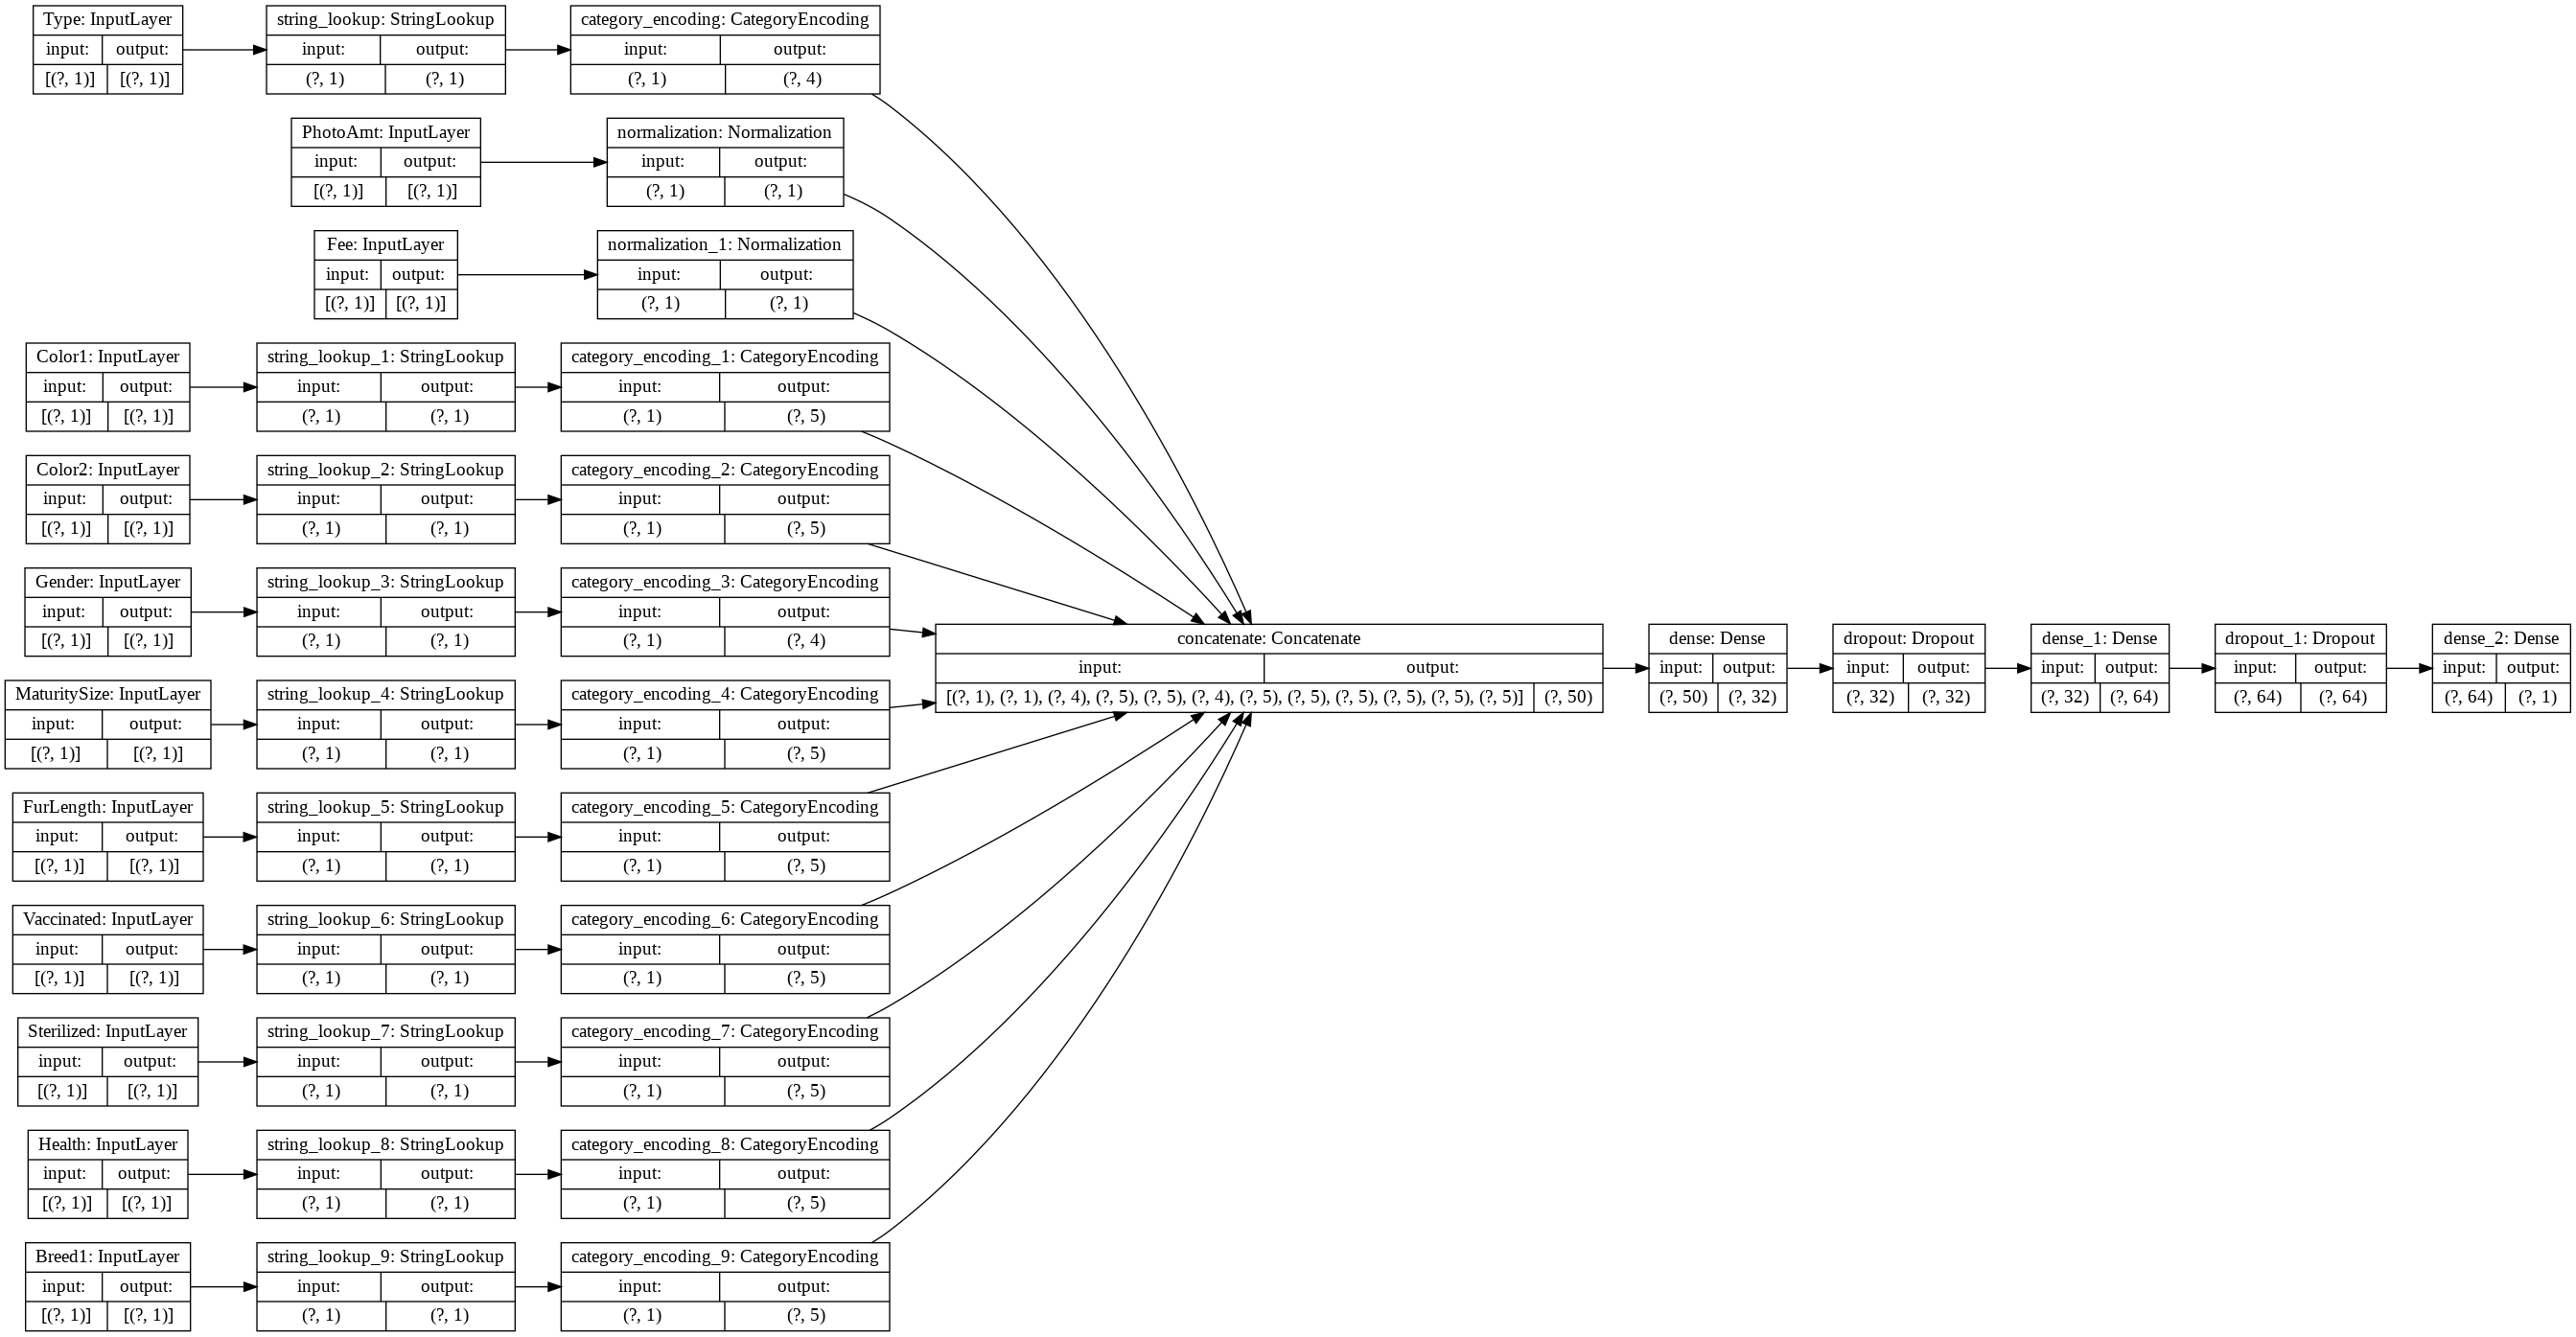

In [23]:
# Convert the feature columns into a tf.keras layer
all_features = tf.keras.layers.concatenate(encoded_features)

# design/build the model
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)

tf.keras.utils.plot_model(model, rankdir='LR', show_shapes=True)

In [24]:
# compile the model
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

In [25]:
# fit the model
model.fit(train_ds, epochs=EPOCHS)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['Age'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


253/253 [==============================] - 4s 14ms/step - loss: 0.6169 - accuracy: 0.6042
Epoch 2/10
253/253 [==============================] - 4s 14ms/step - loss: 0.5634 - accuracy: 0.6937
Epoch 3/10
253/253 [==============================] - 4s 15ms/step - loss: 0.5573 - accuracy: 0.6981
Epoch 4/10
253/253 [==============================] - 4s 15ms/step - loss: 0.5528 - accuracy: 0.7087
Epoch 5/10
253/253 [==============================] - 4s 14ms/step - loss: 0.5512 - accuracy: 0.7173
Epoch 6/10
253/253 [==============================] - 4s 15ms/step - loss: 0.5456 - accuracy: 0.7219
Epoch 7/10
253/253 [==============================] - 4s 15ms/step - loss: 0.5397 - accuracy: 0.7283
Epoch 8/10
253/253 [==============================] - 4s 14ms/step - loss: 0.5385 - accuracy: 0.7331
Epoch 9/10
253/253 [==============================] - 4s 15ms/step - loss: 0.5355 - accuracy: 0.7326
Epoch 10/10
253/253 [==============================] - 4s 15ms/step - loss: 0.5412 - accuracy: 0.7321


## Infer on the test data

In [26]:
res = model.evaluate(test_ds)
print("test loss, test acc:", res)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['Age'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


109/109 [==============================] - 2s 15ms/step - loss: 0.5344 - accuracy: 0.7421
test loss, test acc: [0.534355640411377, 0.7420566082000732]


Note: Since the goal of this tutorial is to demonstrate Tensorflow-IO's capability to stream data from elasticsearch and train `tf.keras` models directly, improving the accuracy of the models is out of the current scope. However, the user can explore the dataset and play around with the feature columns and model architectures to get a better classification performance.

## References:

- [Elasticsearch](https://www.elastic.co/guide/en/elasticsearch/reference/current/targz.html)

- [PetFinder Dataset](https://www.kaggle.com/c/petfinder-adoption-prediction)

- [Classify Structured Data using Keras](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers#create_compile_and_train_the_model)
